In [1]:
import numpy as np 
import pandas as pd 
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, TimeDistributed, Masking
from tensorflow.keras.optimizers import Adam
import h5py
import matplotlib.pyplot as plt
import numpy.ma as ma

In [2]:
from matplotlib.pyplot import figure
plt.rcParams["figure.figsize"] = (20,12)
figure(figsize=(100, 80), dpi=80)

<Figure size 8000x6400 with 0 Axes>

<Figure size 8000x6400 with 0 Axes>

In [3]:
tf.random.set_seed(12345)

In [4]:
# pip install -U numpy==1.18.5

In [5]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

In [6]:
f = h5py.File("rambla_processed_data.h5","r")
scaled_X = ma.array(f["scaled_x"])
scaled_X.mask = ma.array(f["x_mask"])
minX = np.array(f["minX"])
maxX = np.array(f["maxX"])
f.close()

In [7]:
scaled_X

masked_array(
  data=[[0.1449160452324148],
        [0.136245860456123],
        [0.15777259761214607],
        [0.16535831352047828],
        [0.20430432225184125],
        [0.17678718566174276],
        [0.1950402047277661],
        [0.1783752368425989],
        [0.18154251015419343],
        [0.16362423637405146],
        [0.22485603337792878],
        [0.18449170677497764],
        [0.15236050001695653],
        [0.15818897583220595],
        [0.18494356737509246],
        [0.18159742257564113],
        [0.21210313840993988],
        [0.19426336281593154],
        [0.19951802924780218],
        [0.18945532645214896],
        [0.2527061836880512],
        [0.24149329681775314],
        [0.24653074069473083],
        [0.2570274548286095],
        [0.2677450715422401],
        [0.2363579603391307],
        [0.22377844641644237],
        [0.21986434444637507],
        [0.2149850075257186],
        [0.20753158821364928],
        [0.19469780196767017],
        [0.17765204215352148],
    

In [8]:
def inverse_scaler(scaled_x,minX,maxX):
    return scaled_x*maxX-minX

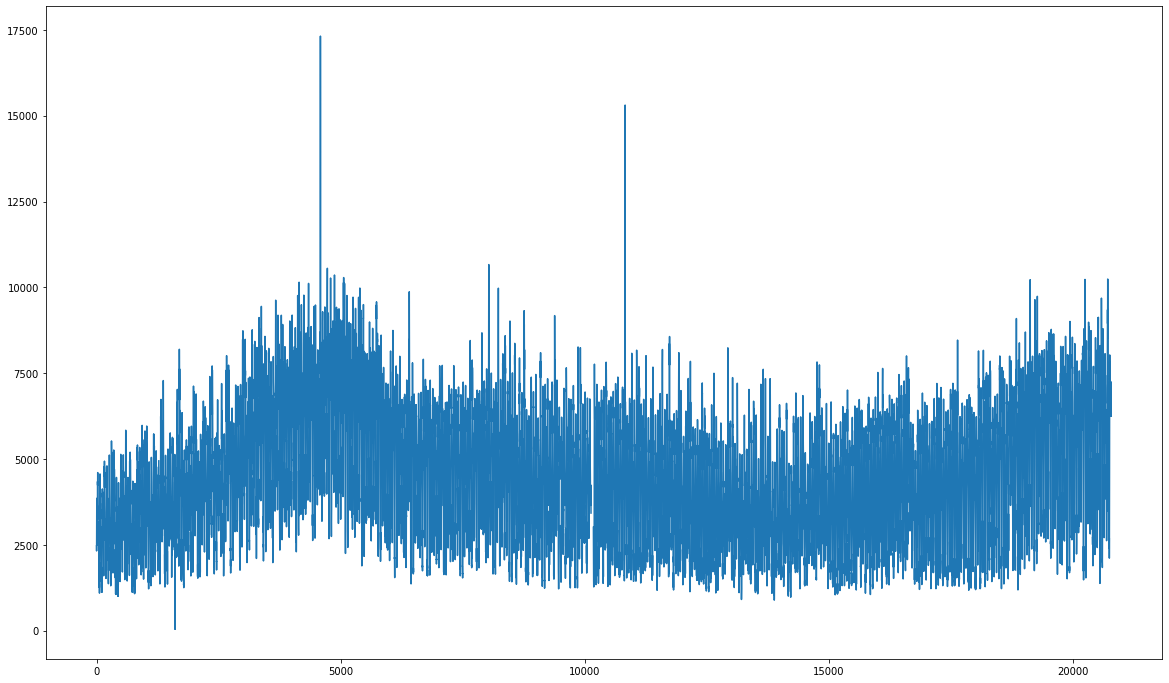

In [9]:
plt.plot(inverse_scaler(scaled_X,minX,maxX))
plt.show()

In [10]:
def partitionSet(test_fraction, data, partitions):
    lenX = len(data)
    test_size = int(len(data) * test_fraction)
    test_df = data[int((partitions/100)*lenX):int((partitions/100)*lenX)+test_size]
    train_df = ma.vstack((data[:int((partitions/100)*lenX)-1],data[int((partitions/100)*lenX)+test_size:]))
    train_df[int((partitions/100)*lenX)] = ma.masked
    return train_df, test_df

train_dataf = []
test_dataf = []

partitions=75

for i in range(1, partitions):
    [train_df,test_df] = partitionSet(0.25,scaled_X,i)
    train_dataf.append(train_df)
    test_dataf.append(test_df)

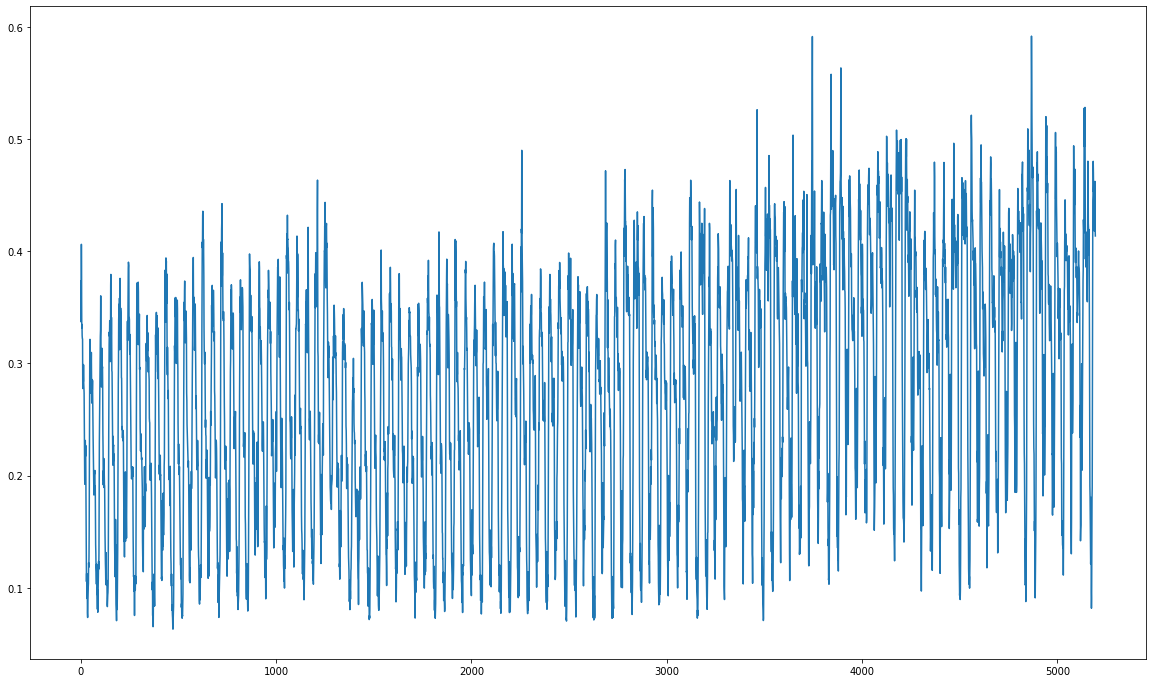

In [11]:
plt.plot(test_dataf[73])
plt.show()

In [12]:
def Dataset(train, test, timesteps):
    X_train = ma.array([train[t:t+timesteps] for t in range(0,len(train)-timesteps)])
    y_train = train[timesteps:, :]
    X_test = ma.array([test[t:t+timesteps] for t in range(0,len(test)-timesteps)])
    y_test = test[timesteps:, :]
    return X_train, y_train, X_test, y_test

train_X_data = []
train_Y_data = []
test_X_data = []
test_Y_data = []


for j in range(0, len(train_dataf)):
    [train_X_dates,train_Y_dates,test_X_dates,test_Y_dates]=Dataset(train_dataf[j],test_dataf[j], 24)
    train_X_data.append(train_X_dates)
    train_Y_data.append(train_Y_dates)
    test_X_data.append(test_X_dates)
    test_Y_data.append(test_Y_dates)

In [13]:
with open('train_X_data.npy', 'wb') as f:
    np.save(f, [train_X_data[i] for i in range(0, len(train_dataf))])

In [14]:
with open('train_Y_data.npy', 'wb') as f:
    np.save(f, [train_Y_data[i] for i in range(0, len(train_dataf))])

In [15]:
with open('test_X_data.npy', 'wb') as f:
    np.save(f, [test_X_data[i] for i in range(0, len(train_dataf))])

In [16]:
with open('test_Y_data.npy', 'wb') as f:
    np.save(f, [test_Y_data[i] for i in range(0, len(train_dataf))])

In [17]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping()

In [18]:
early_stopping = EarlyStopping(monitor = 'val_loss', patience=8, min_delta=0.00001, mode='min')

In [19]:
def LSTM_function(NCells, timesteps, num_features, dropout, NBEpochs, Batchsize, validationSplit, earlystopping, i):
    model = Sequential()
    model.add(Masking(mask_value=0., input_shape=(timesteps, num_features)))
    model.add(LSTM(1, activation = 'tanh', input_shape = (timesteps, num_features), return_sequences=True))
    model.add(Dropout(dropout))
    model.add(LSTM(NCells))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    model.compile(loss = 'mse', optimizer='adam')
    X_ = ma.filled(train_X_data[i],0)
    Y_ = ma.filled(train_Y_data[i],0)
    MODEL = model.fit(X_, Y_, epochs = NBEpochs, batch_size = Batchsize,
                      validation_split = validationSplit, shuffle = False,
                      callbacks=[earlystopping])
    return model, MODEL

In [20]:
df_train = []
df_validation = []
models = []
MODELS = []

datasets = np.arange(0,partitions-1)

for j in datasets:
    [model, MODEL] = LSTM_function(64,np.shape(train_X_data[0])[1], 1, 0.2, 200, 128, 0.2, early_stopping, j)
    df_train.append(MODEL.history['loss'])
    df_validation.append(MODEL.history['val_loss'])
    models.append(model)
    MODELS.append(MODEL)

Epoch 1/200
98/98 [==============================] - 9s 30ms/step - loss: 0.0132 - val_loss: 0.0157
Epoch 2/200
98/98 [==============================] - 1s 14ms/step - loss: 0.0092 - val_loss: 0.0195
Epoch 3/200
98/98 [==============================] - 1s 14ms/step - loss: 0.0090 - val_loss: 0.0150
Epoch 4/200
98/98 [==============================] - 1s 14ms/step - loss: 0.0075 - val_loss: 0.0220
Epoch 5/200
98/98 [==============================] - 1s 14ms/step - loss: 0.0080 - val_loss: 0.0136
Epoch 6/200
98/98 [==============================] - 1s 14ms/step - loss: 0.0057 - val_loss: 0.0149
Epoch 7/200
98/98 [==============================] - 1s 14ms/step - loss: 0.0056 - val_loss: 0.0121
Epoch 8/200
98/98 [==============================] - 1s 14ms/step - loss: 0.0051 - val_loss: 0.0096
Epoch 9/200
98/98 [==============================] - 1s 14ms/step - loss: 0.0048 - val_loss: 0.0085
Epoch 10/200
98/98 [==============================] - 1s 13ms/step - loss: 0.0044 - val_loss: 0.0079

98/98 [==============================] - 1s 14ms/step - loss: 0.0020 - val_loss: 0.0025
Epoch 55/200
98/98 [==============================] - 1s 13ms/step - loss: 0.0019 - val_loss: 0.0025
Epoch 56/200
98/98 [==============================] - 1s 13ms/step - loss: 0.0019 - val_loss: 0.0026
Epoch 57/200
98/98 [==============================] - 1s 13ms/step - loss: 0.0019 - val_loss: 0.0026
Epoch 58/200
98/98 [==============================] - 1s 13ms/step - loss: 0.0019 - val_loss: 0.0026
Epoch 59/200
98/98 [==============================] - 1s 14ms/step - loss: 0.0019 - val_loss: 0.0024
Epoch 60/200
98/98 [==============================] - 1s 13ms/step - loss: 0.0018 - val_loss: 0.0023
Epoch 61/200
98/98 [==============================] - 1s 13ms/step - loss: 0.0019 - val_loss: 0.0024
Epoch 62/200
98/98 [==============================] - 1s 13ms/step - loss: 0.0018 - val_loss: 0.0024
Epoch 63/200
98/98 [==============================] - 1s 13ms/step - loss: 0.0018 - val_loss: 0.0025
Epo

98/98 [==============================] - 1s 15ms/step - loss: 0.0015 - val_loss: 0.0025
Epoch 98/200
98/98 [==============================] - 2s 16ms/step - loss: 0.0015 - val_loss: 0.0024
Epoch 99/200
98/98 [==============================] - 2s 16ms/step - loss: 0.0016 - val_loss: 0.0023
Epoch 100/200
98/98 [==============================] - 2s 16ms/step - loss: 0.0016 - val_loss: 0.0024
Epoch 101/200
98/98 [==============================] - 1s 15ms/step - loss: 0.0015 - val_loss: 0.0023
Epoch 102/200
98/98 [==============================] - 2s 17ms/step - loss: 0.0015 - val_loss: 0.0024
Epoch 103/200
98/98 [==============================] - 2s 17ms/step - loss: 0.0015 - val_loss: 0.0024
Epoch 104/200
98/98 [==============================] - 2s 18ms/step - loss: 0.0015 - val_loss: 0.0024
Epoch 105/200
98/98 [==============================] - 2s 17ms/step - loss: 0.0015 - val_loss: 0.0024
Epoch 106/200
98/98 [==============================] - 2s 17ms/step - loss: 0.0015 - val_loss: 0.0

98/98 [==============================] - 1s 14ms/step - loss: 0.0029 - val_loss: 0.0050
Epoch 19/200
98/98 [==============================] - 1s 14ms/step - loss: 0.0029 - val_loss: 0.0049
Epoch 20/200
98/98 [==============================] - 1s 15ms/step - loss: 0.0029 - val_loss: 0.0049
Epoch 21/200
98/98 [==============================] - 2s 21ms/step - loss: 0.0028 - val_loss: 0.0047
Epoch 22/200
98/98 [==============================] - 1s 14ms/step - loss: 0.0027 - val_loss: 0.0048
Epoch 23/200
98/98 [==============================] - 1s 15ms/step - loss: 0.0027 - val_loss: 0.0048
Epoch 24/200
98/98 [==============================] - 1s 15ms/step - loss: 0.0026 - val_loss: 0.0048
Epoch 25/200
98/98 [==============================] - 1s 15ms/step - loss: 0.0026 - val_loss: 0.0045
Epoch 26/200
98/98 [==============================] - 1s 15ms/step - loss: 0.0026 - val_loss: 0.0044
Epoch 27/200
98/98 [==============================] - 1s 13ms/step - loss: 0.0026 - val_loss: 0.0044
Epo

98/98 [==============================] - 1s 15ms/step - loss: 0.0018 - val_loss: 0.0030
Epoch 67/200
98/98 [==============================] - 1s 15ms/step - loss: 0.0018 - val_loss: 0.0028
Epoch 68/200
98/98 [==============================] - 1s 15ms/step - loss: 0.0018 - val_loss: 0.0030
Epoch 1/200
98/98 [==============================] - 8s 29ms/step - loss: 0.0078 - val_loss: 0.0100
Epoch 2/200
98/98 [==============================] - 1s 13ms/step - loss: 0.0050 - val_loss: 0.0100
Epoch 3/200
98/98 [==============================] - 1s 14ms/step - loss: 0.0042 - val_loss: 0.0095
Epoch 4/200
98/98 [==============================] - 1s 14ms/step - loss: 0.0038 - val_loss: 0.0082
Epoch 5/200
98/98 [==============================] - 1s 14ms/step - loss: 0.0035 - val_loss: 0.0074
Epoch 6/200
98/98 [==============================] - 1s 14ms/step - loss: 0.0031 - val_loss: 0.0066
Epoch 7/200
98/98 [==============================] - 1s 14ms/step - loss: 0.0029 - val_loss: 0.0054
Epoch 8/20

98/98 [==============================] - 2s 17ms/step - loss: 0.0018 - val_loss: 0.0028
Epoch 65/200
98/98 [==============================] - 2s 16ms/step - loss: 0.0018 - val_loss: 0.0027
Epoch 66/200
98/98 [==============================] - 2s 17ms/step - loss: 0.0018 - val_loss: 0.0029
Epoch 67/200
98/98 [==============================] - 2s 16ms/step - loss: 0.0018 - val_loss: 0.0027
Epoch 68/200
98/98 [==============================] - 2s 17ms/step - loss: 0.0018 - val_loss: 0.0029
Epoch 69/200
98/98 [==============================] - 2s 16ms/step - loss: 0.0017 - val_loss: 0.0029
Epoch 70/200
98/98 [==============================] - 2s 15ms/step - loss: 0.0018 - val_loss: 0.0027
Epoch 71/200
98/98 [==============================] - 1s 15ms/step - loss: 0.0018 - val_loss: 0.0028
Epoch 72/200
98/98 [==============================] - 2s 17ms/step - loss: 0.0017 - val_loss: 0.0026
Epoch 73/200
98/98 [==============================] - 2s 17ms/step - loss: 0.0017 - val_loss: 0.0026
Epo

98/98 [==============================] - 2s 18ms/step - loss: 0.0048 - val_loss: 0.0122
Epoch 4/200
98/98 [==============================] - 2s 18ms/step - loss: 0.0039 - val_loss: 0.0095
Epoch 5/200
98/98 [==============================] - 2s 19ms/step - loss: 0.0034 - val_loss: 0.0079
Epoch 6/200
98/98 [==============================] - 2s 18ms/step - loss: 0.0031 - val_loss: 0.0061
Epoch 7/200
98/98 [==============================] - 2s 17ms/step - loss: 0.0029 - val_loss: 0.0054
Epoch 8/200
98/98 [==============================] - 2s 16ms/step - loss: 0.0028 - val_loss: 0.0046
Epoch 9/200
98/98 [==============================] - 2s 15ms/step - loss: 0.0027 - val_loss: 0.0043
Epoch 10/200
98/98 [==============================] - 2s 16ms/step - loss: 0.0025 - val_loss: 0.0044
Epoch 11/200
98/98 [==============================] - 2s 17ms/step - loss: 0.0025 - val_loss: 0.0039
Epoch 12/200
98/98 [==============================] - 1s 15ms/step - loss: 0.0024 - val_loss: 0.0040
Epoch 13/

98/98 [==============================] - 2s 18ms/step - loss: 0.0020 - val_loss: 0.0036
Epoch 67/200
98/98 [==============================] - 2s 18ms/step - loss: 0.0020 - val_loss: 0.0034
Epoch 68/200
98/98 [==============================] - 2s 18ms/step - loss: 0.0019 - val_loss: 0.0035
Epoch 69/200
98/98 [==============================] - 2s 16ms/step - loss: 0.0019 - val_loss: 0.0035
Epoch 70/200
98/98 [==============================] - 2s 17ms/step - loss: 0.0019 - val_loss: 0.0033
Epoch 71/200
98/98 [==============================] - 2s 17ms/step - loss: 0.0019 - val_loss: 0.0034
Epoch 72/200
98/98 [==============================] - 2s 17ms/step - loss: 0.0019 - val_loss: 0.0032
Epoch 73/200
98/98 [==============================] - 2s 17ms/step - loss: 0.0019 - val_loss: 0.0033
Epoch 74/200
98/98 [==============================] - 2s 16ms/step - loss: 0.0019 - val_loss: 0.0034
Epoch 75/200
98/98 [==============================] - 2s 17ms/step - loss: 0.0019 - val_loss: 0.0032
Epo

98/98 [==============================] - 2s 16ms/step - loss: 0.0024 - val_loss: 0.0034
Epoch 29/200
98/98 [==============================] - 2s 16ms/step - loss: 0.0024 - val_loss: 0.0033
Epoch 30/200
98/98 [==============================] - 2s 16ms/step - loss: 0.0024 - val_loss: 0.0033
Epoch 31/200
98/98 [==============================] - 2s 17ms/step - loss: 0.0024 - val_loss: 0.0032
Epoch 32/200
98/98 [==============================] - 2s 16ms/step - loss: 0.0023 - val_loss: 0.0031
Epoch 33/200
98/98 [==============================] - 1s 15ms/step - loss: 0.0023 - val_loss: 0.0032
Epoch 34/200
98/98 [==============================] - 1s 15ms/step - loss: 0.0023 - val_loss: 0.0030
Epoch 35/200
98/98 [==============================] - 2s 16ms/step - loss: 0.0023 - val_loss: 0.0031
Epoch 36/200
98/98 [==============================] - 1s 14ms/step - loss: 0.0023 - val_loss: 0.0030
Epoch 37/200
98/98 [==============================] - 1s 15ms/step - loss: 0.0023 - val_loss: 0.0030
Epo

98/98 [==============================] - 2s 16ms/step - loss: 0.0018 - val_loss: 0.0021
Epoch 108/200
98/98 [==============================] - 2s 16ms/step - loss: 0.0017 - val_loss: 0.0020
Epoch 109/200
98/98 [==============================] - 2s 15ms/step - loss: 0.0017 - val_loss: 0.0021
Epoch 110/200
98/98 [==============================] - 1s 15ms/step - loss: 0.0018 - val_loss: 0.0022
Epoch 111/200
98/98 [==============================] - 2s 15ms/step - loss: 0.0017 - val_loss: 0.0021
Epoch 112/200
98/98 [==============================] - 1s 15ms/step - loss: 0.0017 - val_loss: 0.0021
Epoch 113/200
98/98 [==============================] - 1s 15ms/step - loss: 0.0017 - val_loss: 0.0021
Epoch 114/200
98/98 [==============================] - 1s 15ms/step - loss: 0.0017 - val_loss: 0.0021
Epoch 115/200
98/98 [==============================] - 1s 15ms/step - loss: 0.0017 - val_loss: 0.0021
Epoch 116/200
98/98 [==============================] - 2s 16ms/step - loss: 0.0017 - val_loss: 0

98/98 [==============================] - 1s 12ms/step - loss: 0.0020 - val_loss: 0.0021
Epoch 56/200
98/98 [==============================] - 1s 12ms/step - loss: 0.0019 - val_loss: 0.0022
Epoch 57/200
98/98 [==============================] - 1s 12ms/step - loss: 0.0020 - val_loss: 0.0021
Epoch 58/200
98/98 [==============================] - 1s 12ms/step - loss: 0.0020 - val_loss: 0.0022
Epoch 59/200
98/98 [==============================] - 1s 12ms/step - loss: 0.0020 - val_loss: 0.0021
Epoch 60/200
98/98 [==============================] - 1s 12ms/step - loss: 0.0020 - val_loss: 0.0020
Epoch 61/200
98/98 [==============================] - 1s 12ms/step - loss: 0.0020 - val_loss: 0.0021
Epoch 62/200
98/98 [==============================] - 1s 12ms/step - loss: 0.0019 - val_loss: 0.0022
Epoch 63/200
98/98 [==============================] - 1s 12ms/step - loss: 0.0019 - val_loss: 0.0020
Epoch 64/200
98/98 [==============================] - 1s 12ms/step - loss: 0.0020 - val_loss: 0.0021
Epo

98/98 [==============================] - 1s 11ms/step - loss: 0.0021 - val_loss: 0.0025
Epoch 87/200
98/98 [==============================] - 1s 11ms/step - loss: 0.0020 - val_loss: 0.0025
Epoch 88/200
98/98 [==============================] - 1s 11ms/step - loss: 0.0021 - val_loss: 0.0025
Epoch 89/200
98/98 [==============================] - 1s 11ms/step - loss: 0.0021 - val_loss: 0.0023
Epoch 90/200
98/98 [==============================] - 1s 11ms/step - loss: 0.0020 - val_loss: 0.0024
Epoch 91/200
98/98 [==============================] - 1s 10ms/step - loss: 0.0020 - val_loss: 0.0023
Epoch 92/200
98/98 [==============================] - 1s 10ms/step - loss: 0.0020 - val_loss: 0.0024
Epoch 93/200
98/98 [==============================] - 1s 10ms/step - loss: 0.0020 - val_loss: 0.0023
Epoch 94/200
98/98 [==============================] - 1s 11ms/step - loss: 0.0020 - val_loss: 0.0023
Epoch 95/200
98/98 [==============================] - 1s 10ms/step - loss: 0.0020 - val_loss: 0.0023
Epo

98/98 [==============================] - 1s 9ms/step - loss: 0.0024 - val_loss: 0.0032
Epoch 26/200
98/98 [==============================] - 1s 9ms/step - loss: 0.0023 - val_loss: 0.0031
Epoch 27/200
98/98 [==============================] - 1s 10ms/step - loss: 0.0023 - val_loss: 0.0031
Epoch 28/200
98/98 [==============================] - 1s 9ms/step - loss: 0.0023 - val_loss: 0.0030
Epoch 29/200
98/98 [==============================] - 1s 9ms/step - loss: 0.0023 - val_loss: 0.0031
Epoch 30/200
98/98 [==============================] - 1s 9ms/step - loss: 0.0023 - val_loss: 0.0029
Epoch 31/200
98/98 [==============================] - 1s 9ms/step - loss: 0.0022 - val_loss: 0.0029
Epoch 32/200
98/98 [==============================] - 1s 9ms/step - loss: 0.0022 - val_loss: 0.0029
Epoch 33/200
98/98 [==============================] - 1s 10ms/step - loss: 0.0022 - val_loss: 0.0031
Epoch 34/200
98/98 [==============================] - 1s 9ms/step - loss: 0.0022 - val_loss: 0.0028
Epoch 35/20

98/98 [==============================] - 1s 9ms/step - loss: 0.0055 - val_loss: 0.0076
Epoch 7/200
98/98 [==============================] - 1s 10ms/step - loss: 0.0044 - val_loss: 0.0066
Epoch 8/200
98/98 [==============================] - 1s 11ms/step - loss: 0.0038 - val_loss: 0.0059
Epoch 9/200
98/98 [==============================] - 1s 10ms/step - loss: 0.0035 - val_loss: 0.0050
Epoch 10/200
98/98 [==============================] - 1s 10ms/step - loss: 0.0033 - val_loss: 0.0051
Epoch 11/200
98/98 [==============================] - 1s 10ms/step - loss: 0.0032 - val_loss: 0.0044
Epoch 12/200
98/98 [==============================] - 1s 10ms/step - loss: 0.0031 - val_loss: 0.0041
Epoch 13/200
98/98 [==============================] - 1s 10ms/step - loss: 0.0029 - val_loss: 0.0042
Epoch 14/200
98/98 [==============================] - 1s 10ms/step - loss: 0.0029 - val_loss: 0.0041
Epoch 15/200
98/98 [==============================] - 1s 10ms/step - loss: 0.0028 - val_loss: 0.0041
Epoch 1

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



98/98 [==============================] - 1s 10ms/step - loss: 0.0028 - val_loss: 0.0033
Epoch 30/200
98/98 [==============================] - 1s 9ms/step - loss: 0.0028 - val_loss: 0.0033
Epoch 31/200
98/98 [==============================] - 1s 9ms/step - loss: 0.0028 - val_loss: 0.0031
Epoch 32/200
98/98 [==============================] - 1s 9ms/step - loss: 0.0027 - val_loss: 0.0031
Epoch 33/200
98/98 [==============================] - 1s 9ms/step - loss: 0.0027 - val_loss: 0.0032
Epoch 34/200
98/98 [==============================] - 1s 9ms/step - loss: 0.0027 - val_loss: 0.0031
Epoch 35/200
98/98 [==============================] - 1s 9ms/step - loss: 0.0027 - val_loss: 0.0032
Epoch 36/200
98/98 [==============================] - 1s 9ms/step - loss: 0.0027 - val_loss: 0.0032
Epoch 37/200
98/98 [==============================] - 1s 10ms/step - loss: 0.0027 - val_loss: 0.0031
Epoch 38/200
98/98 [==============================] - 1s 10ms/step - loss: 0.0026 - val_loss: 0.0032
Epoch 39/2

98/98 [==============================] - 1s 10ms/step - loss: 0.0021 - val_loss: 0.0021
Epoch 36/200
98/98 [==============================] - 1s 10ms/step - loss: 0.0022 - val_loss: 0.0021
Epoch 37/200
98/98 [==============================] - 1s 9ms/step - loss: 0.0022 - val_loss: 0.0020
Epoch 38/200
98/98 [==============================] - 1s 9ms/step - loss: 0.0021 - val_loss: 0.0020
Epoch 39/200
98/98 [==============================] - 1s 9ms/step - loss: 0.0021 - val_loss: 0.0020
Epoch 40/200
98/98 [==============================] - 1s 10ms/step - loss: 0.0022 - val_loss: 0.0020
Epoch 41/200
98/98 [==============================] - 1s 10ms/step - loss: 0.0021 - val_loss: 0.0020
Epoch 42/200
98/98 [==============================] - 1s 10ms/step - loss: 0.0022 - val_loss: 0.0021
Epoch 43/200
98/98 [==============================] - 1s 10ms/step - loss: 0.0021 - val_loss: 0.0020
Epoch 44/200
98/98 [==============================] - 1s 10ms/step - loss: 0.0021 - val_loss: 0.0020
Epoch 

98/98 [==============================] - 1s 13ms/step - loss: 0.0035 - val_loss: 0.0039
Epoch 10/200
98/98 [==============================] - 1s 11ms/step - loss: 0.0033 - val_loss: 0.0037
Epoch 11/200
98/98 [==============================] - 1s 11ms/step - loss: 0.0033 - val_loss: 0.0034
Epoch 12/200
98/98 [==============================] - 1s 14ms/step - loss: 0.0032 - val_loss: 0.0032
Epoch 13/200
98/98 [==============================] - 1s 14ms/step - loss: 0.0030 - val_loss: 0.0031
Epoch 14/200
98/98 [==============================] - 1s 12ms/step - loss: 0.0030 - val_loss: 0.0030
Epoch 15/200
98/98 [==============================] - 1s 12ms/step - loss: 0.0029 - val_loss: 0.0029
Epoch 16/200
98/98 [==============================] - 1s 14ms/step - loss: 0.0028 - val_loss: 0.0027
Epoch 17/200
98/98 [==============================] - 1s 12ms/step - loss: 0.0029 - val_loss: 0.0027
Epoch 18/200
98/98 [==============================] - 1s 12ms/step - loss: 0.0028 - val_loss: 0.0025
Epo

98/98 [==============================] - 2s 15ms/step - loss: 0.0068 - val_loss: 0.0124
Epoch 6/200
98/98 [==============================] - 2s 17ms/step - loss: 0.0054 - val_loss: 0.0091
Epoch 7/200
98/98 [==============================] - 1s 15ms/step - loss: 0.0057 - val_loss: 0.0075
Epoch 8/200
98/98 [==============================] - 1s 15ms/step - loss: 0.0051 - val_loss: 0.0071
Epoch 9/200
98/98 [==============================] - 1s 14ms/step - loss: 0.0049 - val_loss: 0.0066
Epoch 10/200
98/98 [==============================] - 2s 16ms/step - loss: 0.0046 - val_loss: 0.0063
Epoch 11/200
98/98 [==============================] - 1s 15ms/step - loss: 0.0045 - val_loss: 0.0057
Epoch 12/200
98/98 [==============================] - 2s 16ms/step - loss: 0.0043 - val_loss: 0.0052
Epoch 13/200
98/98 [==============================] - 2s 16ms/step - loss: 0.0041 - val_loss: 0.0051
Epoch 14/200
98/98 [==============================] - 2s 15ms/step - loss: 0.0040 - val_loss: 0.0049
Epoch 1

98/98 [==============================] - 8s 32ms/step - loss: 0.0098 - val_loss: 0.0123
Epoch 2/200
98/98 [==============================] - 2s 17ms/step - loss: 0.0080 - val_loss: 0.0127
Epoch 3/200
98/98 [==============================] - 2s 17ms/step - loss: 0.0069 - val_loss: 0.0135
Epoch 4/200
98/98 [==============================] - 1s 15ms/step - loss: 0.0069 - val_loss: 0.0134
Epoch 5/200
98/98 [==============================] - 1s 15ms/step - loss: 0.0059 - val_loss: 0.0118
Epoch 6/200
98/98 [==============================] - 1s 15ms/step - loss: 0.0056 - val_loss: 0.0096
Epoch 7/200
98/98 [==============================] - 2s 16ms/step - loss: 0.0052 - val_loss: 0.0083
Epoch 8/200
98/98 [==============================] - 2s 16ms/step - loss: 0.0050 - val_loss: 0.0070
Epoch 9/200
98/98 [==============================] - 1s 15ms/step - loss: 0.0048 - val_loss: 0.0068
Epoch 10/200
98/98 [==============================] - 2s 17ms/step - loss: 0.0046 - val_loss: 0.0064
Epoch 11/20

98/98 [==============================] - 2s 17ms/step - loss: 0.0025 - val_loss: 0.0019
Epoch 37/200
98/98 [==============================] - 2s 16ms/step - loss: 0.0026 - val_loss: 0.0019
Epoch 38/200
98/98 [==============================] - 2s 18ms/step - loss: 0.0024 - val_loss: 0.0019
Epoch 39/200
98/98 [==============================] - 2s 17ms/step - loss: 0.0025 - val_loss: 0.0019
Epoch 40/200
98/98 [==============================] - 2s 18ms/step - loss: 0.0025 - val_loss: 0.0019
Epoch 41/200
98/98 [==============================] - 2s 16ms/step - loss: 0.0024 - val_loss: 0.0019
Epoch 42/200
98/98 [==============================] - 2s 18ms/step - loss: 0.0025 - val_loss: 0.0020
Epoch 43/200
98/98 [==============================] - 2s 18ms/step - loss: 0.0024 - val_loss: 0.0019
Epoch 44/200
98/98 [==============================] - 2s 17ms/step - loss: 0.0024 - val_loss: 0.0019
Epoch 45/200
98/98 [==============================] - 2s 18ms/step - loss: 0.0024 - val_loss: 0.0019
Epo

98/98 [==============================] - 2s 16ms/step - loss: 0.0029 - val_loss: 0.0024
Epoch 34/200
98/98 [==============================] - 1s 15ms/step - loss: 0.0029 - val_loss: 0.0024
Epoch 35/200
98/98 [==============================] - 1s 15ms/step - loss: 0.0028 - val_loss: 0.0025
Epoch 36/200
98/98 [==============================] - 2s 19ms/step - loss: 0.0028 - val_loss: 0.0024
Epoch 37/200
98/98 [==============================] - 2s 17ms/step - loss: 0.0029 - val_loss: 0.0023
Epoch 38/200
98/98 [==============================] - 2s 19ms/step - loss: 0.0027 - val_loss: 0.0023
Epoch 39/200
98/98 [==============================] - 2s 18ms/step - loss: 0.0027 - val_loss: 0.0023
Epoch 40/200
98/98 [==============================] - 2s 16ms/step - loss: 0.0027 - val_loss: 0.0024
Epoch 41/200
98/98 [==============================] - 2s 17ms/step - loss: 0.0027 - val_loss: 0.0022
Epoch 42/200
98/98 [==============================] - 2s 16ms/step - loss: 0.0027 - val_loss: 0.0023
Epo

98/98 [==============================] - 2s 18ms/step - loss: 0.0060 - val_loss: 0.0081
Epoch 6/200
98/98 [==============================] - 2s 19ms/step - loss: 0.0050 - val_loss: 0.0069
Epoch 7/200
98/98 [==============================] - 2s 20ms/step - loss: 0.0045 - val_loss: 0.0055
Epoch 8/200
98/98 [==============================] - 2s 16ms/step - loss: 0.0042 - val_loss: 0.0051
Epoch 9/200
98/98 [==============================] - 2s 17ms/step - loss: 0.0040 - val_loss: 0.0045
Epoch 10/200
98/98 [==============================] - 1s 15ms/step - loss: 0.0038 - val_loss: 0.0043
Epoch 11/200
98/98 [==============================] - 2s 17ms/step - loss: 0.0037 - val_loss: 0.0040
Epoch 12/200
98/98 [==============================] - 2s 15ms/step - loss: 0.0036 - val_loss: 0.0039
Epoch 13/200
98/98 [==============================] - 2s 16ms/step - loss: 0.0035 - val_loss: 0.0039
Epoch 14/200
98/98 [==============================] - 1s 15ms/step - loss: 0.0034 - val_loss: 0.0036
Epoch 1

98/98 [==============================] - 1s 15ms/step - loss: 0.0028 - val_loss: 0.0026
Epoch 28/200
98/98 [==============================] - 2s 16ms/step - loss: 0.0028 - val_loss: 0.0027
Epoch 29/200
98/98 [==============================] - 2s 15ms/step - loss: 0.0027 - val_loss: 0.0024
Epoch 30/200
98/98 [==============================] - 2s 16ms/step - loss: 0.0027 - val_loss: 0.0025
Epoch 31/200
98/98 [==============================] - 2s 17ms/step - loss: 0.0027 - val_loss: 0.0025
Epoch 32/200
98/98 [==============================] - 1s 15ms/step - loss: 0.0026 - val_loss: 0.0024
Epoch 33/200
98/98 [==============================] - 1s 15ms/step - loss: 0.0027 - val_loss: 0.0024
Epoch 34/200
98/98 [==============================] - 2s 17ms/step - loss: 0.0027 - val_loss: 0.0025
Epoch 35/200
98/98 [==============================] - 2s 16ms/step - loss: 0.0026 - val_loss: 0.0025
Epoch 36/200
98/98 [==============================] - 2s 18ms/step - loss: 0.0026 - val_loss: 0.0024
Epo

98/98 [==============================] - 2s 17ms/step - loss: 0.0026 - val_loss: 0.0024
Epoch 29/200
98/98 [==============================] - 1s 14ms/step - loss: 0.0025 - val_loss: 0.0022
Epoch 30/200
98/98 [==============================] - 2s 18ms/step - loss: 0.0025 - val_loss: 0.0022
Epoch 31/200
98/98 [==============================] - 2s 16ms/step - loss: 0.0025 - val_loss: 0.0022
Epoch 32/200
98/98 [==============================] - 2s 16ms/step - loss: 0.0024 - val_loss: 0.0022
Epoch 33/200
98/98 [==============================] - 2s 16ms/step - loss: 0.0025 - val_loss: 0.0022
Epoch 34/200
98/98 [==============================] - 1s 15ms/step - loss: 0.0025 - val_loss: 0.0023
Epoch 35/200
98/98 [==============================] - 1s 15ms/step - loss: 0.0024 - val_loss: 0.0022
Epoch 36/200
98/98 [==============================] - 2s 18ms/step - loss: 0.0025 - val_loss: 0.0022
Epoch 37/200
98/98 [==============================] - 2s 19ms/step - loss: 0.0025 - val_loss: 0.0022
Epo

98/98 [==============================] - 2s 20ms/step - loss: 0.0026 - val_loss: 0.0022
Epoch 56/200
98/98 [==============================] - 1s 15ms/step - loss: 0.0026 - val_loss: 0.0022
Epoch 57/200
98/98 [==============================] - 1s 15ms/step - loss: 0.0026 - val_loss: 0.0022
Epoch 58/200
98/98 [==============================] - 1s 15ms/step - loss: 0.0026 - val_loss: 0.0022
Epoch 59/200
98/98 [==============================] - 2s 16ms/step - loss: 0.0026 - val_loss: 0.0022
Epoch 60/200
98/98 [==============================] - 1s 14ms/step - loss: 0.0026 - val_loss: 0.0022
Epoch 61/200
98/98 [==============================] - 2s 16ms/step - loss: 0.0027 - val_loss: 0.0022
Epoch 1/200
98/98 [==============================] - 8s 34ms/step - loss: 0.0102 - val_loss: 0.0091
Epoch 2/200
98/98 [==============================] - 2s 15ms/step - loss: 0.0068 - val_loss: 0.0081
Epoch 3/200
98/98 [==============================] - 1s 15ms/step - loss: 0.0055 - val_loss: 0.0064
Epoch 

98/98 [==============================] - 2s 18ms/step - loss: 0.0040 - val_loss: 0.0024
Epoch 8/200
98/98 [==============================] - 2s 19ms/step - loss: 0.0038 - val_loss: 0.0022
Epoch 9/200
98/98 [==============================] - 2s 17ms/step - loss: 0.0037 - val_loss: 0.0021
Epoch 10/200
98/98 [==============================] - 2s 18ms/step - loss: 0.0036 - val_loss: 0.0020
Epoch 11/200
98/98 [==============================] - 2s 17ms/step - loss: 0.0035 - val_loss: 0.0019
Epoch 12/200
98/98 [==============================] - 2s 18ms/step - loss: 0.0034 - val_loss: 0.0018
Epoch 13/200
98/98 [==============================] - 2s 16ms/step - loss: 0.0033 - val_loss: 0.0018
Epoch 14/200
98/98 [==============================] - 1s 15ms/step - loss: 0.0033 - val_loss: 0.0017
Epoch 15/200
98/98 [==============================] - 1s 14ms/step - loss: 0.0032 - val_loss: 0.0017
Epoch 16/200
98/98 [==============================] - 1s 14ms/step - loss: 0.0031 - val_loss: 0.0017
Epoch

In [21]:
for i in datasets:
    models[i].save('/home/costa/Institute/ModelsForAlicante/Rambla/models/RamblaModel'+str(i)+'.h5')

In [ ]:
for i in datasets:
    MODELS[i].save('/home/costa/Institute/ModelsForAlicante/Rambla/MODELS/RamblaModel'+str(i)+'.h5')

In [22]:
train_performance = []
for i in datasets:
    train_performance.append(np.array(df_train[i]))

In [23]:
val_performance = []
for i in datasets:
    val_performance.append(np.array(df_validation[i]))

In [24]:
with open('train_performance.npy', 'wb') as f:
    np.save(f, [train_performance[i] for i in datasets])

In [25]:
with open('val_performance.npy', 'wb') as f:
    np.save(f, [val_performance[i] for i in datasets])

In [1]:
import re #python regular expression matching module
script = re.sub(r'# In\[.*\]:\n','',open('3.0-Model.py').read())
with open('3.0-ModelScript.py','w') as fh:
    fh.write(script)